# ViTGAN pytorch implementation

This notebook is a pytorch implementation of [VITGAN: Training GANs with Vision Transformers](https://arxiv.org/pdf/2107.04589v1.pdf)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1kJJw6BYW01HgooCZ2zUDt54e1mXqITXH?usp=sharing)

The model consists of a Vision Transformer Generator and a Vision Transformer Discriminator.

It is adversarially trained to map latent vectors to images, which closely resemble the images from a given dataset. In this implementation, the dataset used is CIFAR-10.

The Generator takes latent values $z$ as input, which is integrated in a Vision Transformer Encoder. The output for each patch of the image is fed to a SIREN network, in combination with a Fourier Embedding ($E_{fou}$)

![ViTGAN Generator architecture](https://drive.google.com/uc?export=view&id=1XaCVOLq8Bvg-I3qM-bugNZcjIW5L7XTO)

This implementation separates the Generator in Vision Transformer and SIREN networks for debugging purposes.

1.   [x] Use vectorized L2 distance in attention for **Discriminator**
2.   [x] Overlapping Image Patches
2.   [x] DiffAugment
3.   [x] Self-modulated LayerNorm (SLN)
4.   [x] Implicit Neural Representation for Patch Generation
5.   [x] ExponentialMovingAverage (EMA)
6.   [x] Balanced Consistency Regularization (bCR)
7.   [x] Improved Spectral Normalization

In [ ]:
! pip install einops
! pip install git+https://github.com/fadel/pytorch_ema
! pip install stylegan2-pytorch
! pip install tensorboard

In [2]:
%load_ext tensorboard

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn import Parameter
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.utils import make_grid

from torch_ema import ExponentialMovingAverage

from stylegan2_pytorch import stylegan2_pytorch

from torch.utils.tensorboard import SummaryWriter

Hyperparameters

In [4]:
image_size = 32
patch_size = 4
latent_dim = 32 # Size of z
hidden_features = 384
depth = 4
num_heads = 4

combine_patch_embeddings = True # Generate an image from a single SIREN, instead of patch-by-patch
combine_patch_embeddings_size = hidden_features

sln_paremeter_size = hidden_features # either hidden_features or 1

batch_size = 128
device = "cuda"
out_features = 3 # The number of color channels

discriminator_type = "stylegan2" # "vitgan", "cnn", "stylegan2"

lr = 3e-5 # Learning rate
beta = (0, 0.99) # Adam oprimizer parameters for both the generator and the discriminator
batch_size_history_discriminator = True # Whether to use a loss, which tracks one sample from last batch_size number of batches
epochs = 200 # Number of epochs
lambda_bCR_real = 10
lambda_bCR_fake = 10
lambda_lossD_noise = 0
lambda_lossD_history = 0

writer = SummaryWriter(log_dir=f'runs/patch_size-{patch_size}_\
hidden_features-{hidden_features}_combine_patch_embeddings-{combine_patch_embeddings}_\
sln_paremeter_size-{sln_paremeter_size}_discriminator_type-{discriminator_type}_\
num_heads-num_heads_\
depth-{depth}')

In [5]:
if combine_patch_embeddings:
    out_patch_size = image_size
    combined_embedding_size = combine_patch_embeddings_size
else:
    out_patch_size = patch_size
    combined_embedding_size = hidden_features

siren_in_features = combined_embedding_size

siren_mapping_size = int(siren_in_features // 2)
B_gauss = torch.randn((siren_mapping_size, 2)) * 10

In [6]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid



https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment-stylegan2-pytorch/DiffAugment_pytorch.py

In [7]:
def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.1):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.3):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


Visualize the effects of the DiffAugment

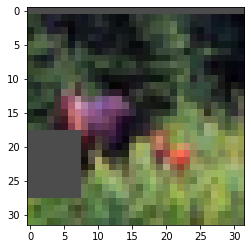

In [9]:
img = next(iter(trainloader))[0]
img = DiffAugment(img, policy='color,translation,cutout', channels_first=True)
img = img.permute(0,2,3,1)[0]
img -= img.min()
img /= img.max()
plt.imshow(img)

# Improved Spectral Normalization (ISN)

$$
\bar{W}_{ISN}(W):=\sigma(W_{init})\cdot W/\sigma(W)
$$

Reference code: https://github.com/koshian2/SNGAN

When updating the weights, normalize the weights' norm to its norm at initialization.

In [10]:
def l2normalize(v, eps=1e-4):
	return v / (v.norm() + eps)

class spectral_norm(nn.Module):
	def __init__(self, module, name='weight', power_iterations=1):
		super().__init__()
		self.module = module
		self.name = name
		self.power_iterations = power_iterations
		if not self._made_params():
			self._make_params()
		self.w_init_sigma = None

	def _update_u_v(self):
		u = getattr(self.module, self.name + "_u")
		v = getattr(self.module, self.name + "_v")
		w = getattr(self.module, self.name + "_bar")

		height = w.data.shape[0]
		_w = w.view(height, -1)
		for _ in range(self.power_iterations):
			v = l2normalize(torch.matmul(_w.t(), u))
			u = l2normalize(torch.matmul(_w, v))

		sigma = u.dot((_w).mv(v))
		if type(self.w_init_sigma) != np.ndarray:
			self.w_init_sigma = np.array(sigma.expand_as(w).detach().cpu())
		setattr(self.module, self.name, torch.tensor(self.w_init_sigma).to(device) * w / sigma.expand_as(w))

	def _made_params(self):
		try:
			getattr(self.module, self.name + "_u")
			getattr(self.module, self.name + "_v")
			getattr(self.module, self.name + "_bar")
			return True
		except AttributeError:
			return False

	def _make_params(self):
		w = getattr(self.module, self.name)

		height = w.data.shape[0]
		width = w.view(height, -1).data.shape[1]

		u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
		v = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
		u.data = l2normalize(u.data)
		v.data = l2normalize(v.data)
		w_bar = Parameter(w.data)

		del self.module._parameters[self.name]
		self.module.register_parameter(self.name + "_u", u)
		self.module.register_parameter(self.name + "_v", v)
		self.module.register_parameter(self.name + "_bar", w_bar)

	def forward(self, *args):
		self._update_u_v()
		return self.module.forward(*args)

Vision Transformer reference code: \[[Blog Post](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)\]

Normal Attention Mechanism

$$
Attention_h(X) = softmax \bigg ( \frac{QK^T}{\sqrt{d_h}} V \bigg )
$$

Lipschitz Attention Mechanism

$$
Attention_h(X) = softmax \bigg ( \frac{d(Q,K)}{\sqrt{d_h}} V \bigg )
$$

where $d(Q,K)$ is L2-distance.

https://arxiv.org/pdf/2006.04710.pdf

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=384, num_heads=4, dropout=0, discriminator=False):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.discriminator = discriminator
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        if self.discriminator:
            self.qkv = spectral_norm(self.qkv)
            self.projection = spectral_norm(self.projection)
        
    def forward(self, x, mask=None):
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        if self.discriminator:
            # calculate L2-distances
            energy = torch.cdist(queries.contiguous(), keys.contiguous(), p=2)
        else:
            # sum up over the last axis
            energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

# Generator

In [12]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

Self-Modulated LayerNorm
$$
SLN(h_{\ell},w)=\gamma_{\ell}(w)\odot\frac{h_{\ell}-\mu}{\sigma}+\beta_{\ell}(w)
$$

where $\gamma_{\ell}, \beta_{\ell}\in \mathbb{R}^D$ or $\gamma_{\ell}, \beta_{\ell}\in \mathbb{R}^1$

In [13]:
class SLN(nn.Module):
    def __init__(self, input_size, parameter_size=None):
        super().__init__()
        if parameter_size == None:
            parameter_size = input_size
        self.ln = nn.LayerNorm(input_size)
        self.gamma = nn.Linear(input_size, parameter_size)
        self.beta = nn.Linear(input_size, parameter_size)

    def forward(self, hidden, w):
        gamma = self.gamma(w).unsqueeze(1)
        beta = self.beta(w).unsqueeze(1)
        ln = self.ln(hidden)
        return gamma * ln + beta

In [14]:
class GeneratorTransformerEncoderBlock(nn.Module):
    def __init__(self,
                 hidden_size=384,
                 sln_paremeter_size=384,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.,
                 **kwargs):
        super().__init__()
        self.sln = SLN(hidden_size, parameter_size=sln_paremeter_size)
        self.msa = MultiHeadAttention(hidden_size, **kwargs)
        self.dropout = nn.Dropout(drop_p)
        self.feed_forward = FeedForwardBlock(hidden_size, expansion=forward_expansion, drop_p=forward_drop_p)

    def forward(self, hidden, w):
        res = hidden
        hidden = self.sln(hidden, w)
        hidden = self.msa(hidden)
        hidden = self.dropout(hidden)
        hidden += res

        res = hidden
        hidden = self.sln(hidden, w)
        self.feed_forward(hidden)
        hidden = self.dropout(hidden)
        hidden += res
        return hidden

In [15]:
class GeneratorTransformerEncoder(nn.Module):
    def __init__(self, depth=4, **kwargs):
        self.depth = depth
        self.blocks = [GeneratorTransformerEncoderBlock(**kwargs).to(device) for _ in range(depth)]
        super().__init__()
    
    def forward(self, hidden, w):
        for i in range(self.depth):
            hidden = self.blocks[i](hidden, w)
        return hidden

In [16]:
class GeneratorViT(nn.Module):
    def __init__(self,
                patch_size=4,
                latent_dim=32,
                hidden_size=384,
                sln_paremeter_size=1,
                image_size=32,
                depth=4,
                combine_patch_embeddings=False,
                combined_embedding_size=1024,
                **kwargs):
        super().__init__()
        self.hidden_size = hidden_size
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 384),
            nn.GELU(),
        )
        num_patches = int(image_size//patch_size)**2
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.image_size = image_size
        self.combine_patch_embeddings = combine_patch_embeddings
        self.combined_embedding_size = combined_embedding_size

        self.pos_emb = nn.Parameter(torch.randn(num_patches, hidden_size))
        self.transformer_encoder = GeneratorTransformerEncoder(depth, hidden_size=hidden_size, **kwargs)
        self.sln = SLN(hidden_size, parameter_size=sln_paremeter_size).to(device)
        self.to_single_emb = nn.Sequential(
            nn.Linear(num_patches*hidden_size, combined_embedding_size),
            nn.GELU(),
        )

    def forward(self, z):
        w = self.mlp(z)
        pos = repeat(torch.sin(self.pos_emb), 'n e -> b n e', b=z.shape[0])
        hidden = self.transformer_encoder(pos, w)

        if self.combine_patch_embeddings:
            # Output [batch_size, combined_embedding_size]
            hidden = self.sln(hidden, w).view((z.shape[0], -1))
            hidden = self.to_single_emb(hidden)
        else:
            # Output [batch_size*num_patches, hidden_size]
            hidden = self.sln(hidden, w).view((-1, self.hidden_size))
        
        return hidden

# SIREN

Code for SIREN is taken from [SIREN reference colab notebook](https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb)

In [17]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

$$
Fou(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}
$$

In [18]:
def fourier_input_mapping(x):
    x_proj = (2. * np.pi * x) @ B_gauss.t()
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

def fourier_pos_embedding():
    # Create input pixel coordinates in the unit square
    coords = np.linspace(-1, 1, out_patch_size, endpoint=True)
    pos = np.stack(np.meshgrid(coords, coords), -1)
    pos = torch.tensor(pos, dtype=torch.float)
    result = fourier_input_mapping(pos).reshape([out_patch_size**2, siren_in_features])
    return result.to(device)

def mix_hidden_and_pos(hidden):
    pos = fourier_pos_embedding()
    hidden = repeat(hidden, 'n h -> n p h', p = out_patch_size**2)

    # Combine the outputs from the Vision Transformer
    # with the Fourier position embeddings
    result = hidden + pos
    
    return result

# Discriminator

In [19]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, stride_size=4, emb_size=384, image_size=32, batch_size=64):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            spectral_norm(nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=stride_size)).to(device),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        num_patches = ((image_size-patch_size+stride_size) // stride_size) **2 + 1
        self.positions = nn.Parameter(torch.randn(num_patches, emb_size))
        self.batch_size = batch_size

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += torch.sin(self.positions)
        return x

In [20]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [21]:
class DiscriminatorTransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=384,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.,
                 **kwargs):
        super().__init__(
                ResidualAdd(nn.Sequential(
                    nn.LayerNorm(emb_size),
                    MultiHeadAttention(emb_size, **kwargs),
                    nn.Dropout(drop_p)
                )),
                ResidualAdd(nn.Sequential(
                    nn.LayerNorm(emb_size),
                    nn.Sequential(
                        spectral_norm(nn.Linear(emb_size, forward_expansion * emb_size)),
                        nn.GELU(),
                        nn.Dropout(forward_drop_p),
                        spectral_norm(nn.Linear(forward_expansion * emb_size, emb_size)),
                    ),
                    nn.Dropout(drop_p)
                )
            ))

In [22]:
class DiscriminatorTransformerEncoder(nn.Sequential):
    def __init__(self, depth=4, **kwargs):
        super().__init__(*[DiscriminatorTransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=384, class_size_1=4098, class_size_2=1024, class_size_3=512, n_classes=10):
        super().__init__(
            nn.LayerNorm(emb_size),
            spectral_norm(nn.Linear(emb_size, class_size_1)),
            nn.GELU(),
            spectral_norm(nn.Linear(class_size_1, class_size_2)),
            nn.GELU(),
            spectral_norm(nn.Linear(class_size_2, class_size_3)),
            nn.GELU(),
            spectral_norm(nn.Linear(class_size_3, n_classes)),
            nn.GELU(),
        )

    def forward(self, x):
        # Take only the cls token outputs
        x = x[:, 0, :]
        return super().forward(x)

In [23]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels=3,
                patch_size=4,
                stride_size=4,
                emb_size=384,
                image_size=32,
                depth=4,
                n_classes=1,
                diffaugment='color,translation,cutout',
                **kwargs):
        self.diffaugment = diffaugment
        super().__init__(
            PatchEmbedding(in_channels, patch_size, stride_size, emb_size, image_size),
            DiscriminatorTransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes=n_classes)
        )
    
    def forward(self, img, do_augment=True):
        if do_augment:
            img = DiffAugment(img, policy=self.diffaugment)
        return super().forward(img)

# CNN Discriminator

In [24]:
class CNN(nn.Sequential):
    def __init__(self,
                diffaugment='color,translation,cutout',
                **kwargs):
        self.diffaugment = diffaugment
        super().__init__(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,1)
        )
    
    def forward(self, img, do_augment=True):
        if do_augment:
            img = DiffAugment(img, policy=self.diffaugment)
        return super().forward(img)

# StyleGAN2 Discriminator

In [25]:
class StyleGanDiscriminator(stylegan2_pytorch.Discriminator):
    def __init__(self,
                diffaugment='color,translation,cutout',
                **kwargs):
        self.diffaugment = diffaugment
        super().__init__(**kwargs)
    def forward(self, img, do_augment=True):
        if do_augment:
            img = DiffAugment(img, policy=self.diffaugment)
        out, _ = super().forward(img)
        return out

# Experiments

In [26]:
# Create the Generator
Generator = GeneratorViT(   patch_size=patch_size,
                            image_size=image_size,
                            latent_dim=latent_dim,
                            combine_patch_embeddings=combine_patch_embeddings,
                            combined_embedding_size=combined_embedding_size,
                            sln_paremeter_size=sln_paremeter_size,
                            num_heads = num_heads,
                            depth = depth,
                         ).to(device)

# Create the SIREN network
img_siren = Siren(in_features=siren_in_features, out_features=out_features, hidden_features=hidden_features,
                  hidden_layers=3, outermost_linear=True).to(device)

# Create the two types of discriminators
Discriminator = ViT(discriminator=True,
                            stride_size=patch_size*2,
                            n_classes=1, 
                            num_heads = num_heads,
                            depth = depth,
                    ).to(device)
cnn_discriminator = CNN().to(device)
stylegan2_discriminator = StyleGanDiscriminator(image_size=32).to(device)

# Testing the generator

Train to match fixed latent values to fixed images

In [27]:
total_steps = 1001 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

lr = 3e-5

params = list(Generator.parameters()) + list(img_siren.parameters())
optim = torch.optim.Adam(lr=lr, params=params)
ema = ExponentialMovingAverage(params, decay=0.995)

ground_truth, _ = next(iter(trainloader))
ground_truth = ground_truth.permute(0, 2, 3, 1).view((-1, image_size**2, out_features))
ground_truth = ground_truth.to(device)

z = torch.randn([batch_size, latent_dim]).to(device)

In [ ]:
for step in range(total_steps):
    hidden = Generator(z)
    siren_input = mix_hidden_and_pos(hidden).to(device)
    model_output, coords = img_siren(siren_input)
    # convert model_output from [batch_size*num_patches, patch_size^2, out_features]
    # to [batch_size, image_size^2, out_features]
    model_output = model_output.view([-1, image_size**2, out_features])
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(2,8, figsize=(24,6))
        for i in range(8):
            j = np.random.randint(0, batch_size-1)
            img = model_output[j].cpu().view(32,32,3).detach().numpy()
            img -= img.min()
            img /= img.max()
            axes[0,i].imshow(img)
            g_img = ground_truth[j].cpu().view(32,32,3).detach().numpy()
            g_img -= g_img.min()
            g_img /= g_img.max()
            axes[1,i].imshow(g_img)

        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()
    ema.update()

In [ ]:
%tensorboard --logdir runs/

# Training

In [ ]:
os.makedirs("weights", exist_ok = True)
os.makedirs("samples", exist_ok = True)

# Loss function
criterion = nn.BCEWithLogitsLoss()

if discriminator_type == "cnn": discriminator = cnn_discriminator
elif discriminator_type == "stylegan2": discriminator = stylegan2_discriminator
elif discriminator_type == "vitgan": discriminator = Discriminator

params = list(Generator.parameters()) + list(img_siren.parameters())
optim_g = torch.optim.Adam(lr=lr, params=params, betas=beta)
optim_d = torch.optim.Adam(lr=lr, params=discriminator.parameters(), betas=beta)
ema = ExponentialMovingAverage(params, decay=0.995)

fixed_noise = torch.FloatTensor(np.random.normal(0, 1, (16, latent_dim))).to(device)

discriminator_f_img = torch.zeros([batch_size, 3, image_size, image_size]).to(device)

trainset_len = len(trainloader.dataset)

step = 0
for epoch in range(epochs):
    for batch_id, batch in enumerate(trainloader):
        step += 1

        # Train discriminator

        # Forward + Backward with real images
        r_img = batch[0].to(device)
        r_logit = discriminator(r_img).flatten()
        r_label = torch.ones(r_logit.shape[0]).to(device)

        lossD_real = criterion(r_logit, r_label)
        
        lossD_bCR_real = F.mse_loss(r_logit, discriminator(r_img, do_augment=False))

        # Forward + Backward with fake images
        latent_vector = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        hidden = Generator(latent_vector)
        model_input = mix_hidden_and_pos(hidden).to(device)
        model_output, coords = img_siren(model_input)
        # convert model_output from [batch_size*num_patches, patch_size^2, out_features]
        f_img = model_output.view([-1, image_size, image_size, out_features])
        f_img = f_img.permute(0, 3, 1, 2).contiguous()

        f_label = torch.zeros(batch_size).to(device)
        # Save the a single generated image to the discriminator training data
        if batch_size_history_discriminator:
            discriminator_f_img[step % batch_size] = f_img[0].detach()
            f_logit_history = discriminator(discriminator_f_img).flatten()
            lossD_fake_history = criterion(f_logit_history, f_label)
        else: lossD_fake_history = 0
        # Train the discriminator on the images, generated only from this batch
        f_logit = discriminator(f_img).flatten()
        lossD_fake = criterion(f_logit, f_label)
        
        lossD_bCR_fake = F.mse_loss(f_logit, discriminator(f_img, do_augment=False))
        
        f_noise_input = torch.FloatTensor(np.random.rand(*f_img.shape)*2 - 1).to(device)
        f_noise_logit = discriminator(f_noise_input).flatten()
        lossD_noise = criterion(f_noise_logit, f_label)

        lossD = lossD_real * 0.5 +\
                lossD_fake * 0.5 +\
                lossD_fake_history * lambda_lossD_history +\
                lossD_noise * lambda_lossD_noise +\
                lossD_bCR_real * lambda_bCR_real +\
                lossD_bCR_fake * lambda_bCR_fake

        optim_d.zero_grad()
        lossD.backward()
        optim_d.step()
        
        # Train Generator

        latent_vector = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        hidden = Generator(latent_vector)
        model_input = mix_hidden_and_pos(hidden).to(device)
        model_output, coords = img_siren(model_input)
        # convert model_output from [batch_size*num_patches, patch_size^2, out_features]
        f_img = model_output.view([-1, image_size, image_size, out_features])
        f_img = f_img.permute(0, 3, 1, 2)

        f_logit = discriminator(f_img).flatten()
        r_label = torch.ones(batch_size).to(device)
        lossG = criterion(f_logit, r_label)
        
        optim_g.zero_grad()
        lossG.backward()
        optim_g.step()
        ema.update()

        writer.add_scalar("Loss/Generator", lossG, step)
        writer.add_scalar("Loss/Dis(real)", lossD_real, step)
        writer.add_scalar("Loss/Dis(fake)", lossD_fake, step)
        writer.add_scalar("Loss/Dis(fake_history)", lossD_fake_history, step)
        writer.add_scalar("Loss/Dis(noise)", lossD_noise, step)
        writer.add_scalar("Loss/Dis(bCR_fake)", lossD_bCR_fake * lambda_bCR_fake, step)
        writer.add_scalar("Loss/Dis(bCR_real)", lossD_bCR_real * lambda_bCR_real, step)
        writer.flush()

        if batch_id%20 == 0:
            print(f'epoch {epoch}/{epochs}; batch {batch_id}/{int(trainset_len/batch_size)}')
            print(f'Generator: {"{:.3f}".format(float(lossG))}, '+\
                  f'Dis(real): {"{:.3f}".format(float(lossD_real))}, '+\
                  f'Dis(fake): {"{:.3f}".format(float(lossD_fake))}, '+\
                  f'Dis(fake_history): {"{:.3f}".format(float(lossD_fake_history))}, '+\
                  f'Dis(noise) {"{:.3f}".format(float(lossD_noise))}, '+\
                  f'Dis(bCR_fake): {"{:.3f}".format(float(lossD_bCR_fake * lambda_bCR_fake))}, '+\
                  f'Dis(bCR_real): {"{:.3f}".format(float(lossD_bCR_real * lambda_bCR_real))}')

            # Plot 8 randomly selected samples
            fig, axes = plt.subplots(1,8, figsize=(24,3))
            for i in range(8):
                j = np.random.randint(0, batch_size-1)
                model_output = model_output.view([-1, image_size**2, out_features])
                img = model_output[j].cpu().view(32,32,3).detach().numpy()
                img -= img.min()
                img /= img.max()
                axes[i].imshow(img)
            plt.show()

    # if step % sample_interval == 0:
    Generator.eval()
    hidden = Generator(fixed_noise)
    model_input = mix_hidden_and_pos(hidden).to(device)
    model_output, coords = img_siren(model_input)
    f_img = model_output.view([-1, image_size, image_size, out_features])
    vis = f_img.permute(0, 3, 1, 2)
    vis.detach().cpu()
    vis = make_grid(vis, nrow = 4, padding = 5, normalize = True)
    
    writer.add_image(f'Generated/epoch_{epoch}', vis)

    vis = T.ToPILImage()(vis)
    vis.save('samples/vis{:03d}.jpg'.format(epoch))
    Generator.train()
    print("Save sample to samples/vis{:03d}.jpg".format(epoch))

    # Save the checkpoints.
    torch.save(Generator.state_dict(), 'weights/Generator.pth')
    torch.save(discriminator.state_dict(), 'weights/discriminator.pth')
    print("Save model state.")

writer.close()